In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Load data
train_df = pd.read_csv("../sales_train.csv.gz")
test_df  = pd.read_csv("../test.csv.gz")

categories = pd.read_csv('../item_categories.csv')
items = pd.read_csv('../items.csv')
shops = pd.read_csv('../shops.csv')

In [2]:
%store -r __prepare_data_4

In [3]:
%%time
__prepare_data_4

CPU times: user 3min 8s, sys: 1min 50s, total: 4min 59s
Wall time: 5min 15s


In [4]:
# based on tables from 2019.11.16/trends_combined.ipynb I choose those shops to be taken out:
closed_shops = [0, 1, 8, 9, 11, 13, 17, 20, 23,  27,  29, 30, 32, 33,  36,  40, 43, 54]

# one of those, though, needs to be predicted (#36):
print(test_df[test_df.shop_id.isin(closed_shops)].shop_id.unique())

# and one of those (#51) does not (keep it for training anyways):
print(set(all_data.shop_id.unique()).difference(test_df.shop_id.unique()))

from calendar import monthrange

# January, 2013 is date_block_num==0
timeline = pd.DataFrame({'begin_date': pd.date_range(start='2013-01-01',end='2015-11-01', freq='MS'),
                         'date_block_num': range(35)} )
    
timeline['n_days'] = timeline.begin_date.apply(lambda date: monthrange(date.year,date.month)[1])

timeline['workdays'] = [17, 20, 20, 22, 18, 19, 23, 22, 21, 23, 20, 22,
                        17, 20, 20, 22, 19, 19, 23, 21, 22, 23, 18, 23,
                        15, 19, 21, 22, 18, 21, 23, 21, 22, 22, 20]

[36]
{0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54}


In [5]:
no_stock_items = []
discontinued_items = []

total_monthly_item_sales_good = (all_data[~ all_data.shop_id.isin(closed_shops)]
                                 .groupby(["date_block_num", "item_id"]).agg({'target': [np.mean, sum]})).reset_index()

total_monthly_item_sales_good.columns = ["date_block_num", "item_id", "average_sales", "total_sales"]

for item in total_monthly_item_sales_good.item_id.unique():

    sales = (total_monthly_item_sales_good[total_monthly_item_sales_good.item_id==item]
             .groupby(["date_block_num"])
             .agg({'average_sales': lambda x: np.NA if x.empty else x.iloc[0],
                   'total_sales':   lambda x: np.NA if x.empty else x.iloc[0]})
             .reset_index())

    if not len(sales.index):
        continue

    sales = pd.merge(sales[["average_sales", "total_sales", "date_block_num"]],
                     timeline,
                     how='right',
                     on=['date_block_num']).sort_values(by=['date_block_num'])

    start = sales.iloc[min( np.where(~ np.isnan(sales.average_sales))[0] ),].date_block_num
    end   = sales.iloc[max( np.where(~ np.isnan(sales.average_sales))[0] ),].date_block_num
#    print("start: %d, end: %d" % (start,end))

    # last months sales are present, but not enough lags for seasonal inference => ignore
    if start+12 >= end:
        no_stock_items.append(item)
        continue

    # there should be sales in last month, otherwise consider it is discontinued
    if end < 33:
        discontinued_items.append(item)
        continue
        
    # at least last 3 month with sales should be present
    if sum(~ np.isnan(sales.average_sales[-3:])) < 3:
        no_stock_items.append(item)
        continue

other_items = set(test_df.item_id.unique()).intersection(set(no_stock_items))
print("Not easily forecastable are %d items" % len(other_items))

Not easily forecastable are 3183 items


In [142]:
#the line below proves that every shop is tested on the same number of items:
#test_df.groupby(['shop_id']).agg({'item_id': len})

#res1 = pd.read_csv("../2019.12.28/two_components_one_seasonal_123.csv")
#res2 = pd.read_csv("../2019.12.28/_no_seasonal_predictors_ref_123.csv")
res1 = pd.read_csv("../macro4_123.csv")
#res2 = pd.read_csv("../2019.12.28/similar2_macro4_123.csv")
res2 = pd.read_csv("../2019.12.31/macro4_123_allshops_s0.8.csv")

res1 = pd.merge(res1, test_df, how='left', on=['ID'])
res2 = pd.merge(res2, test_df, how='left', on=['ID'])

res = pd.merge(res1, res2, how='inner', on=['ID', 'shop_id', 'item_id', 'date_block_num'])

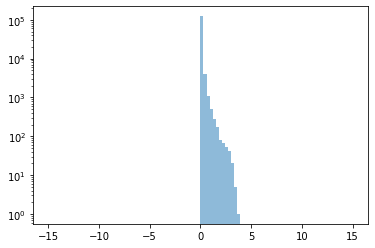

In [143]:
other = res[res.item_id.isin(other_items) & (res.shop_id!=36)]
plt.hist(other.item_cnt_month_x-other.item_cnt_month_y, bins=100, range=[-15, 15], alpha=0.5)
plt.yscale('log')
plt.show()

In [16]:
res3 = res[np.abs(res.item_cnt_month_x-res.item_cnt_month_y)<5]
res3 = res3[['ID','item_cnt_month_y']]
res3.columns = ['ID','item_cnt_month']

res4 = res[np.abs(res.item_cnt_month_x-res.item_cnt_month_y)>=5]
res4 = res4[['ID','item_cnt_month_x']]
res4.columns = ['ID','item_cnt_month']

pd.concat([res3,res4]).sort_values(['ID']).to_csv("./surrogate_gt5.csv", index=False)

In [ ]:
# clear evidence that targets >5 makes public score changing between ~0.9 and ~1.0. Is tail distorted by date #33?

In [96]:
retain = res1[res1.item_cnt_month>5]
test = pd.merge(test_df, retain[["shop_id","item_id","item_cnt_month"]], how='left', on=["shop_id","item_id"]).fillna(0).reset_index()
test[['ID', 'item_cnt_month']].to_csv("./macro4_le5eq0.csv", index=False)

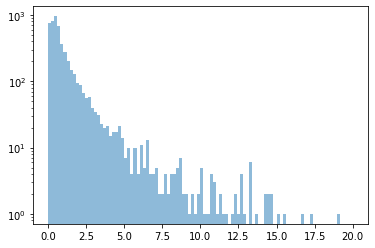

In [85]:
plt.hist(res1[res1.shop_id==25].item_cnt_month, bins=100, range=[0, 20], alpha=0.5)
plt.yscale('log')
plt.show()

In [97]:
gt5sales = res1.groupby(['shop_id']).agg({'item_cnt_month': lambda x: sum(x>5)})
np.median(gt5sales.item_cnt_month)

22.0

In [62]:
items_to_forecast = test_df.item_id.unique()
closed_shops = [0, 1, 8, 9, 11, 13, 17, 20, 23,  27,  29, 30, 32, 33,  36,  40, 43, 54]
train = all_data[(all_data.date_block_num < 34)&(~all_data.shop_id.isin(closed_shops))&(all_data.item_id.isin(items_to_forecast))].fillna(0)

In [66]:
train[train.date_block_num == 33].groupby(['shop_id']).agg({'target': lambda x: sum(x>10)})

,target
shop_id,
2,4.0
3,5.0
4,3.0
5,5.0
6,11.0
7,11.0
10,2.0
12,13.0
14,6.0


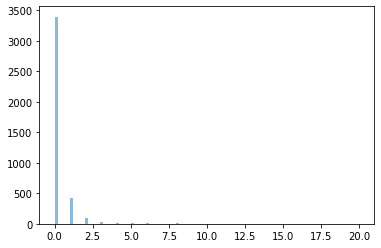

In [70]:
month_33 = train[train.date_block_num == 33]
plt.hist(month_33[month_33.shop_id==5].target, bins=100, range=[0, 20], alpha=0.5)
#plt.yscale('log')
plt.show()

In [88]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(res1.item_cnt_month, [0]*len(res1.clip(0,5).item_cnt_month)))
print("RMSE forecastable: %f" % (rmse))
print("Average forecastable: {0}".format(np.mean(res1.item_cnt_month)))

RMSE forecastable: 0.944594
Average forecastable: 0.3400578460550887


In [ ]:
# but public score for clipping at 5 jumps to 1.15866

In [127]:
shop25 = res1[res1.shop_id==25]
shop25.item_cnt_month *= 0.9
result = pd.concat([shop25, res1[res1.shop_id!=25]]).sort_values(by=["shop_id","item_id"])
test = pd.merge(test_df, result[["shop_id","item_id","item_cnt_month"]], how='left', on=["shop_id","item_id"]).fillna(0).reset_index()
test[['ID', 'item_cnt_month']].to_csv("./macro4_shop25s0.9.csv", index=False)

In [122]:
shop25.shape

(5100, 6)

In [137]:
res1.item_cnt_month *= 0.8
test = pd.merge(test_df, res1[["shop_id","item_id","item_cnt_month"]], how='left', on=["shop_id","item_id"]).fillna(0).reset_index()
test[['ID', 'item_cnt_month']].to_csv("./macro4_123_allshops_s0.8.csv", index=False)